## Create a model that is able to predict both Age and gender based on the image presented


In [35]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
import pandas as pd, numpy as np
import os
print(os.getcwd())

import face_alignment
from skimage import io


/Users/robertocandelario/Documents/Python Projects/Age_Gender_Classification


In [2]:
path = os.path.join(os.getcwd(), "fairface-img-margin025-trainval/")

In [3]:
trn_df = pd.read_csv(path + 'fairface-labels-train.csv')
val_df = pd.read_csv(path + 'fairface-labels-val.csv')
print(val_df.iloc[5])
print()
print(val_df.iloc[5].squeeze())
f = val_df.iloc[5].squeeze()
f.file

file                  val/6.jpg
age                          35
gender                     Male
race            Latino_Hispanic
service_test              False
Name: 5, dtype: object

file                  val/6.jpg
age                          35
gender                     Male
race            Latino_Hispanic
service_test              False
Name: 5, dtype: object


'val/6.jpg'

### Build a subclass Dataset 
    the subclass will take a dataframe and makes the required transformations.


In [4]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen
    
    def preprocess_image(self, im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/225.)
        return im[None]
    
    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)
            
            ages.append(float(int(age)/80))
            genders.append(float(gender))
            
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)
            
        return ims, ages, genders

## Define the dataloaders
    The dataloaders help pull batches of data for the model to be trained on


In [5]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

train_loader = DataLoader(trn, batch_size=32, shuffle=True,
                        drop_last=True,collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32,
                        collate_fn=val.collate_fn)

a,b,c, = next(iter(train_loader))
print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


## Get the pretrained model
    Free the current parameters and change the last layer 

In [6]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    ### Build a nn.Module class. This class will help us split the model to predict classification and sequential 
    
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            
            # First layer 
            self.intermediate = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU()
            )
            
            # Next two layers are the ending layers 
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    # define the loss function for both gender and age 
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_functions, optimizer

model, criterion, optimizer = get_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define function to train model on a batch

In [7]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), gender)
    
    # add both losses and perform back propagation
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

### Define validation-batch method
    Pass in correct values to see if the model is able to predict the correct values after being trained on an epoch 

In [8]:
def validate_batch(data, model, criteria):
    img, age, gender = data
    model.eval()
    with torch.no_grad():
        pred_gender, pred_age = model(img)
        gender_criterion, age_criterion = criteria
        gender_loss = gender_criterion(pred_gender.squeeze(), gender)
        age_loss = age_criterion(pred_age.squeeze(), age)
        
        total_loss = gender_loss + age_loss
        
        pred_gender = (pred_gender > 0.5).squeeze()
        gender_accuracy = (pred_gender == gender).float().sum()
        
        age_mae = torch.abs(age-pred_age).float().sum()
        return total_loss, gender_accuracy, age_mae


### Train model over 5 epochs

In [24]:
import time
model, criteria, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []
n_epochs = 10
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
    print(epoch+1)
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    
    # First loop, train the model
    print("Working on training")
    for ix, data in enumerate(train_loader):
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item() # Adding all the batches losses to get the total loss of the epoch 
    
    
    # Second loop, validate the model performance 
    print("Working on Validaiton")
    for ix, data in enumerate(test_loader):
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        
        # add all the batch values togetehr 
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])
        
    # calc the overall accuracy of age prediction and gender classification
    val_age_mae /= ctr 
    val_gender_acc /= ctr 
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)
        
        
    # Log metrics for each epoch: 

    best_test_loss = min(best_test_loss, epoch_test_loss)
    # Print progress and estimated time remaining
    elapsed_time = time.time() - start
    remaining_time = (n_epochs - epoch) * (elapsed_time / (epoch + 1))
    print(f"{epoch + 1}/{n_epochs} ({elapsed_time:.2f}s elapsed - {remaining_time:.2f}s remaining)")

    # Create formatted output for epoch details
    info = (
        f"Epoch: {epoch + 1:03d}\n"
        f"  Train Loss: {epoch_train_loss:.3f}\n"
        f"  Test Loss: {epoch_test_loss:.3f}\n"
        f"  Best Test Loss: {best_test_loss:.4f}\n"
        f"  Gender Accuracy: {val_gender_acc * 100:.2f}%\n"
        f"  Age MAE: {val_age_mae:.2f}\n"
    )

    # Print the detailed epoch information
    print(info)
    # Append metrics for plots
    val_gender_accuracies.append(val_gender_acc * 100)
    val_age_maes.append(val_age_mae)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_test_loss)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1
Working on training
Working on Validaiton
1/10 (479.23s elapsed - 4792.33s remaining)
Epoch: 001
  Train Loss: 0.659
  Test Loss: 0.863
  Best Test Loss: 0.8626
  Gender Accuracy: 82.93%
  Age MAE: 14.75

2
Working on training
Working on Validaiton
2/10 (918.01s elapsed - 4131.04s remaining)
Epoch: 002
  Train Loss: 0.460
  Test Loss: 0.856
  Best Test Loss: 0.8563
  Gender Accuracy: 84.29%
  Age MAE: 15.33

3
Working on training
Working on Validaiton
3/10 (1350.44s elapsed - 3601.17s remaining)
Epoch: 003
  Train Loss: 0.336
  Test Loss: 0.875
  Best Test Loss: 0.8563
  Gender Accuracy: 84.47%
  Age MAE: 15.27

4
Working on training
Working on Validaiton
4/10 (1781.86s elapsed - 3118.25s remaining)
Epoch: 004
  Train Loss: 0.228
  Test Loss: 0.921
  Best Test Loss: 0.8563
  Gender Accuracy: 83.91%
  Age MAE: 15.22

5
Working on training
Working on Validaiton
5/10 (2191.83s elapsed - 2630.19s remaining)
Epoch: 005
  Train Loss: 0.151
  Test Loss: 1.007
  Best Test Loss: 0.8563
  Gend

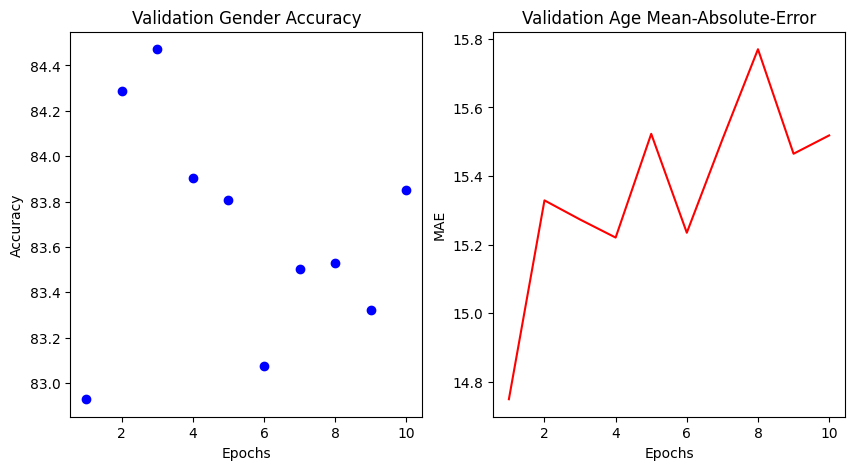

In [25]:
epochs = np.arange(1, (n_epochs + 1))
val_gender_accuracies_np = torch.tensor(val_gender_accuracies).cpu().numpy()
val_age_maes_np = torch.tensor(val_age_maes).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flat
ax[0].plot(epochs, val_gender_accuracies_np, 'bo')
ax[1].plot(epochs, val_age_maes_np, 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[1].set_title('Validation Age Mean-Absolute-Error')
plt.show()

False


[ WARN:0@16716.101] global loadsave.cpp:241 findDecoder imread_('IMG_3420.jpg'): can't open/read file: check file path/integrity


ValueError: Image could not be loaded. Please check the file path.

Image dtype: uint8
Image shape: (3088, 2316, 3)
Predicted Gender: Male, Age: [[2.5620288e-08]]


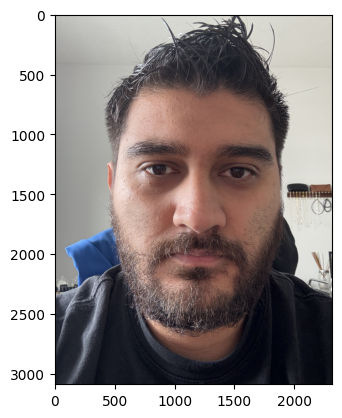

In [34]:
from PIL import Image
import pillow_heif
import numpy as np

# Load HEIC image
heif_file = pillow_heif.read_heif("IMG_3428.HEIC")
im = Image.frombytes(
    heif_file.mode, 
    heif_file.size, 
    heif_file.data
)

plt.imshow(im)
# Convert to RGB and ensure proper format
im = im.convert("RGB")  # Ensure the image is in RGB format
im_np = np.array(im, dtype=np.uint8)  # Convert to numpy array

# Debugging output
print(f"Image dtype: {im_np.dtype}")  # Expect uint8
print(f"Image shape: {im_np.shape}")  # Expect (height, width, 3)

# Preprocess the image
im_tensor = trn.preprocess_image(im_np).to(device)

# Pass the preprocessed image to the model
gender, age = model(im_tensor)

# Extract predictions
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

print(f"Predicted Gender: {'Female' if pred_gender > 0.5 else 'Male'}, Age: {pred_age}")